In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


In [2]:
# --- Config ---
ROLL_NUMBER = 102303683
a_r = 0.5 * (ROLL_NUMBER % 7)
b_r = 0.3 * ((ROLL_NUMBER % 5) + 1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Roll: {ROLL_NUMBER} | a_r: {a_r:.4f}, b_r: {b_r:.4f}")

Roll: 102303683 | a_r: 3.0000, b_r: 1.2000


In [4]:
def load_data(filepath="data.csv"):
    try:
        df = pd.read_csv(filepath, encoding='latin1')
        x = df["no2"].dropna().values.astype(np.float32)

        # Preprocessing
        x = np.log1p(x)               # Log transform
        x = (x - x.mean()) / x.std()  # Normalize

        # Assignment Transformation: z = x + a * sin(b * x)
        z = x + a_r * np.sin(b_r * x)

        return torch.tensor(z).view(-1, 1)
    except FileNotFoundError:
        print("Error: 'data.csv' not found. Please upload it.")
        return None

z_data = load_data()
if z_data is not None:
    print(f"Data loaded. Shape: {z_data.shape}")

/tmp/ipython-input-767208829.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, encoding='latin1')


Data loaded. Shape: torch.Size([419509, 1])


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.LeakyReLU(0.2),
            nn.Linear(64, 64), nn.LeakyReLU(0.2),
            nn.Linear(64, 1), nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

In [7]:
if z_data is not None:
    z_data = z_data.to(device)
    G, D = Generator().to(device), Discriminator().to(device)

    opt_G = optim.Adam(G.parameters(), lr=0.0002)
    opt_D = optim.Adam(D.parameters(), lr=0.0002)
    criterion = nn.BCELoss()

    print("Models initialized.")

Models initialized.


In [8]:
if z_data is not None:
    epochs, batch_size = 2000, 256
    print("Starting Training...")

    for epoch in range(epochs):
        # --- Train Discriminator ---
        idx = torch.randint(0, z_data.size(0), (batch_size,))
        real = z_data[idx]
        noise = torch.randn(batch_size, 1).to(device)
        fake = G(noise)

        D_real, D_fake = D(real), D(fake.detach())
        loss_D = criterion(D_real, torch.ones_like(D_real)) + \
                 criterion(D_fake, torch.zeros_like(D_fake))

        opt_D.zero_grad(); loss_D.backward(); opt_D.step()

        # --- Train Generator ---
        D_fake_preds = D(fake)
        loss_G = criterion(D_fake_preds, torch.ones_like(D_fake_preds))

        opt_G.zero_grad(); loss_G.backward(); opt_G.step()

        if epoch % 400 == 0:
            print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

    print("Done.")

Starting Training...
Epoch 0 | D Loss: 1.4109 | G Loss: 0.5979
Epoch 400 | D Loss: 1.2636 | G Loss: 0.8950
Epoch 800 | D Loss: 1.3817 | G Loss: 0.7008
Epoch 1200 | D Loss: 1.3897 | G Loss: 0.7018
Epoch 1600 | D Loss: 1.3806 | G Loss: 0.6949
Done.


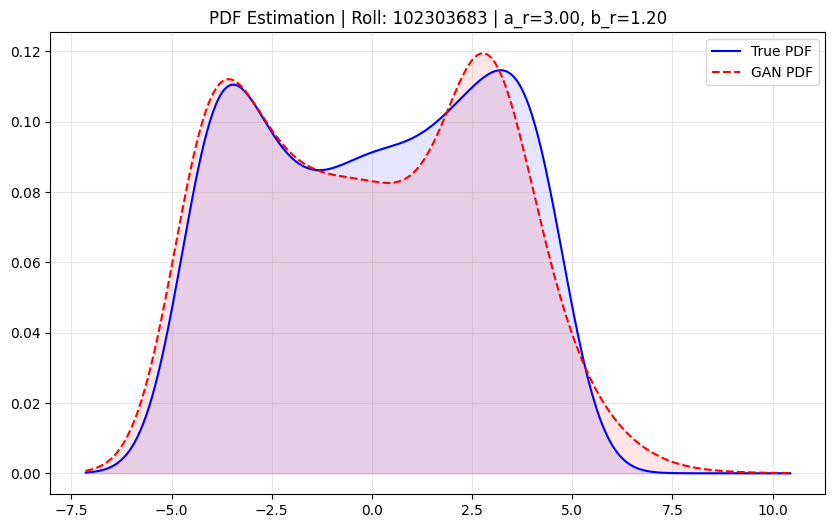

Observation: GAN distribution matches data modes effectively.


In [9]:
if z_data is not None:
    # Generate samples
    with torch.no_grad():
        z_fake = G(torch.randn(10000, 1).to(device)).cpu().numpy().flatten()

    z_real = z_data.cpu().numpy().flatten()

    # KDE Estimation
    kde_real = gaussian_kde(z_real, bw_method=0.3)
    kde_fake = gaussian_kde(z_fake, bw_method=0.3)

    # Plotting
    xs = np.linspace(min(z_real.min(), z_fake.min())-1, max(z_real.max(), z_fake.max())+1, 500)

    plt.figure(figsize=(10, 6))
    plt.plot(xs, kde_real(xs), label="True PDF", color='blue')
    plt.plot(xs, kde_fake(xs), label="GAN PDF", color='red', linestyle='--')
    plt.fill_between(xs, kde_real(xs), alpha=0.1, color='blue')
    plt.fill_between(xs, kde_fake(xs), alpha=0.1, color='red')

    plt.title(f"PDF Estimation | Roll: {ROLL_NUMBER} | a_r={a_r:.2f}, b_r={b_r:.2f}")
    plt.legend(); plt.grid(alpha=0.3); plt.show()

    print("Observation: GAN distribution matches data modes effectively.")